In [1]:
!pip install torch
!pip install torchvision
! pip install scikit-image

#Limpia los registros generados
from IPython.display import clear_output

clear_output()
# print("Todas las librerías han sido instaladas correctamente.")

## Instalación de librerias

In [2]:
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.utils.data as data
import torchvision.transforms as T
import torchvision.models as models
import pickle
from tqdm import tqdm
from skimage.transform import resize

from sklearn.model_selection import GridSearchCV, PredefinedSplit
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

import mlflow, os, pathlib
import mlflow.sklearn
import mlflow.xgboost
import pandas as pd

In [3]:
# carpeta local (cámbiala si quieres)
mlruns_dir = pathlib.Path.cwd() / "mlruns"
mlflow.set_tracking_uri(mlruns_dir.as_uri())
print("Tracking URI:", mlflow.get_tracking_uri())


Tracking URI: file:///mnt/disk/amlopeza/CancerLLMRes/code/dev/Microproyecto/code/mlruns


In [4]:
experiment = mlflow.set_experiment("cervical_cancer_xgboost")

2025/09/04 17:52:38 INFO mlflow.tracking.fluent: Experiment with name 'cervical_cancer_xgboost' does not exist. Creating a new experiment.


In [5]:
mlflow.sklearn.autolog(log_models=True)   # logs GridSearchCV, best_estimator_, params, metrics
mlflow.xgboost.autolog(log_models=False)  # optional: logs XGB train metrics; keep model logging to sklearn

## Load Datasets

In [6]:
train_dataset = pickle.load(open('../data/X_train_raw.pk', 'rb'))
val_dataset = pickle.load(open('../data/X_val_raw.pk', 'rb'))
test_dataset = pickle.load(open('../data/X_test_raw.pk', 'rb'))

In [7]:
train_dataset["Target"][:1200].value_counts(), val_dataset["Target"].value_counts() 

(Target
 0    736
 1    464
 Name: count, dtype: int64,
 Target
 0    2552
 1     721
 Name: count, dtype: int64)

In [8]:
train_dataset.head()

,path,Patient ID,Disease Type,image,Target
0,/src/Micro-proyecto_Cancer_data/manifest/TCGA-...,TCGA-VS-A9UT,Mucinous Adenocarcinoma of Endocervical Type,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",1
1,/src/Micro-proyecto_Cancer_data/manifest/TCGA-...,TCGA-VS-A9UP,Mucinous Adenocarcinoma of Endocervical Type,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",1
2,/src/Micro-proyecto_Cancer_data/manifest/TCGA-...,TCGA-VS-A8EJ,Cervical Squamous Cell Carcinoma,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",0
3,/src/Micro-proyecto_Cancer_data/manifest/TCGA-...,TCGA-VS-A9V2,Cervical Squamous Cell Carcinoma,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",0
4,/src/Micro-proyecto_Cancer_data/manifest/TCGA-...,TCGA-VS-A9UR,Mucinous Adenocarcinoma of Endocervical Type,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",1


In [9]:
train_dataset['Disease Type'].value_counts()

Disease Type
Cervical Squamous Cell Carcinoma                8517
Mucinous Adenocarcinoma of Endocervical Type    5118
Name: count, dtype: int64

In [10]:
val_dataset['Target'][:2000].value_counts()

Target
0    1548
1     452
Name: count, dtype: int64

In [11]:
X_train = train_dataset["image"]
y_train = train_dataset["Target"]

X_val = val_dataset["image"]
y_val = val_dataset["Target"]

X_test = test_dataset["image"]
y_test = test_dataset["Target"]


In [12]:
X_train.shape, X_val.shape, X_test.shape

((13635,), (3273,), (2227,))

In [13]:
X_train[0].shape

(1, 384, 384)

In [14]:
len(X_train) # (N,C, W, H)

13635

In [15]:
shapes = [x.shape for x in X_train]
unique_shapes = set(shapes)
print("Formas únicas en X_train:", unique_shapes)


Formas únicas en X_train: {(1, 640, 640), (1, 672, 672), (1, 512, 448), (1, 384, 348), (1, 512, 512), (1, 576, 576), (1, 144, 144), (1, 384, 360), (1, 252, 256), (1, 208, 320), (1, 384, 384), (1, 448, 448), (1, 252, 320), (1, 480, 480), (1, 232, 320), (1, 448, 512), (1, 320, 320), (1, 1008, 1008), (1, 880, 880), (1, 288, 288), (1, 256, 256), (1, 128, 128), (1, 212, 320), (1, 720, 720), (1, 64, 64), (1, 960, 960), (1, 240, 320), (1, 220, 320), (1, 432, 432), (1, 256, 252), (1, 560, 560), (1, 480, 512), (1, 864, 864), (1, 768, 768), (1, 704, 704), (1, 336, 336), (1, 112, 112)}


En vista de que las imagenes no tienen el mismo size se decide hacer resize a 512 x 512

In [16]:
#Resize all images to 512,512
def resize_image_to512(dataset):
    dataset_fixed = []
    for x in dataset:
        if x.shape != (1,512,512):
            # quitar canal si lo tiene
            img = x[0] if x.ndim == 3 else x
            # redimensionar
            img_resized = resize(img, (512,512), preserve_range=True, anti_aliasing=True)
            # volver a poner canal
            img_resized = img_resized[np.newaxis, ...]
            dataset_fixed.append(img_resized.astype(np.float32))
        else:
            dataset_fixed.append(x.astype(np.float32))
    #To convert to array again
    dataset_fixed = np.concatenate(dataset_fixed)
    return dataset_fixed


In [17]:
#Resize X_train, X_val, X_test
X_train = resize_image_to512(X_train)
X_val = resize_image_to512(X_val)
X_test = resize_image_to512(X_test)

In [18]:
X_train.shape, X_val.shape, X_test.shape

((13635, 512, 512), (3273, 512, 512), (2227, 512, 512))

## Get embeddings ResNet

In [15]:


# ===== Dataset para slices 2D =====
class Slices2D(data.Dataset):
    def __init__(self, images_2d, transform=None):
        """
        images_2d: lista/array de np.ndarray con shape (H, W), en escala de grises
        """
        self.images = images_2d
        self.t = transform

    def _to_pil_rgb(self, img2d):
        im = img2d.astype(np.float32)
        # Normalización simple por slice (z-score)
        # im = (im - im.mean()) / (im.std() + 1e-6)
        # Escala a [0,255] para poder convertir a imagen
        im = im - im.min()
        im = im / (im.max() + 1e-6)
        im = (im * 255.0).clip(0,255).astype(np.uint8)
        # Repite canal: gris -> RGB
        rgb = np.stack([im, im, im], axis=-1)
        return Image.fromarray(rgb)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        x = self._to_pil_rgb(self.images[idx])
        if self.t:
            x = self.t(x)
        return x

# ===== Transforms para ResNet50 (ImageNet) =====
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(imagenet_mean, imagenet_std),
])

# ===== DataLoader =====
def make_loader(images, batch_size=16):
    ds = Slices2D(images, transform=transform)
    return data.DataLoader(ds, batch_size=batch_size, shuffle=False, num_workers=1)

# ===== Modelo ResNet50 como extractor =====
def get_resnet50_encoder():
    weights = models.ResNet50_Weights.IMAGENET1K_V2
    backbone = models.resnet50(weights=weights)
    # quitar la capa FC -> nos quedamos con el penúltimo nivel
    encoder = nn.Sequential(*list(backbone.children())[:-1])  # (B, 2048, 1, 1)
    encoder.eval()
    for p in encoder.parameters():
        p.requires_grad = False
    return encoder

# ===== Función para extraer embeddings =====
@torch.no_grad()
def extract_embeddings(images, batch_size=16, device=None):
    loader = make_loader(images, batch_size)
    encoder = get_resnet50_encoder().to(device or "cpu")

    feats = []
    for xb in tqdm(loader, desc="Extrayendo embeddings"):
        xb = xb.to(device or "cpu", non_blocking=True)
        z = encoder(xb)             # (B, 2048, 1, 1)
        z = z.view(z.size(0), -1)   # (B, 2048)
        feats.append(z.cpu().numpy())

    X = np.concatenate(feats, axis=0)
    return X # (N, 2048)


In [16]:
# Detectar GPU automáticamente
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando device:", device)

# Semilla para reproducibilidad
torch.manual_seed(42)
np.random.seed(42)

Usando device: cuda


In [18]:
X_train_emb = extract_embeddings(X_train, batch_size = 32)
X_val_emb = extract_embeddings(X_val, batch_size = 32)
X_test_emb = extract_embeddings(X_test, batch_size = 32)

Extrayendo embeddings: 100%|█████████████████████████████████████████████████████| 70/70 [02:07<00:00,  1.82s/it]


In [19]:
pickle.dump([X_train_emb, X_val_emb, X_test_emb], open('../data/data_emb_ResNet.pk', 'wb'))

## Load Embeddings

In [19]:
embeddings = pickle.load(open('../data/data_emb_ResNet.pk', 'rb'))
X_train_emb, X_val_emb, X_test_emb = embeddings


In [20]:
X_train_emb.shape, X_val_emb.shape, X_test_emb.shape

((13635, 2048), (3273, 2048), (2227, 2048))

In [21]:
y_train.shape, y_val.shape, y_test.shape

((13635,), (3273,), (2227,))

In [24]:
pickle.dump([y_train, y_val, y_test], open('../data/labels_train_val_test.pk', 'wb'))

## Training XGBoost Mlflow ResNet Embeddings

In [1]:
import pathlib, mlflow
mlruns_dir = pathlib.Path("/home/ubuntu/mlruns")  # usa ruta absoluta y fija
mlflow.set_tracking_uri(mlruns_dir.as_uri())
print("Tracking URI:", mlflow.get_tracking_uri())

Tracking URI: file:///home/ubuntu/mlruns


In [3]:
%pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 MB 31.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.5/322.5 MB 2.6 MB/s eta 0:00:00:00:0100:01
Note: you may need to restart the kernel to use updated packages.


In [7]:
# ---- Imports ----
import numpy as np
import pandas as pd
import pickle

import mlflow.sklearn
import mlflow.xgboost

from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score
from mlflow.models.signature import infer_signature

# ---------- MLflow setup ----------
mlflow.set_experiment("cancer_cervical_ResNet_emb_xgb")
mlflow.sklearn.autolog(log_models=False)   # dejamos el log manual del modelo al final

# ---------- Datos y split (train + val para GridSearchCV con PredefinedSplit) ----------
embeddings = pickle.load(open('../code/data_emb_ResNet.pk', 'rb'))
X_train_emb, X_val_emb, X_test_emb = embeddings
# X_train_emb = X_train_emb['pool']
# X_val_emb = X_val_emb['pool']
# X_test_emb = X_test_emb['pool']

labels = pickle.load(open('../code/labels_train_val_test.pk', 'rb'))
y_train,y_val, y_test = labels



X = np.concatenate([X_train_emb, X_val_emb])
y = np.concatenate([y_train, y_val])

# Indica a GridSearch que use val como "test fold" durante CV
test_fold = np.concatenate([
    -1 * np.ones(len(X_train_emb), dtype=int),  # training samples
    np.zeros(len(X_val_emb), dtype=int)         # validation fold
])
cv = PredefinedSplit(test_fold)

# ---------- Balance de clases ----------
n_neg = np.sum(y_train == 0)
n_pos = np.sum(y_train == 1)
spw = float(n_neg) / float(n_pos)  # scale_pos_weight

# ---------- Hiperparámetros base ----------
n_estimators     = 130
subsample        = 0.7
reg_alpha        = 1.0
min_child_weight = 3.0
reg_lambda       = 0.0
gamma            = 7.0
learning_rate    = 0.3

# ---------- Estimador ----------
xgb = XGBClassifier(
    tree_method='hist',      # CPU
    eval_metric='mlogloss',
    random_state=42,
    n_estimators=n_estimators,
    subsample=subsample,
    reg_alpha=reg_alpha,
    min_child_weight=min_child_weight,
    reg_lambda=reg_lambda,
    gamma=gamma,
    learning_rate=learning_rate,
    scale_pos_weight=spw
)

# ---------- Búsqueda de hiperparámetros ----------
xgb_param_grid = {
    'max_depth': [3, 6],   # se barrerá sobre este
}

grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=xgb_param_grid,
    cv=cv,               # usa el PredefinedSplit (train vs val)
    n_jobs=3,           
    verbose=2,
    scoring='f1_macro',
    refit=True
)

# ---------- Run de MLflow ----------
with mlflow.start_run(run_name="ResNet_emb_xgb_cls"):
    # Entrenar búsqueda
    grid_search.fit(X, y)

    # ----- Log de parámetros (mejores + base) -----
    # mejores del grid
    mlflow.log_params({f"best__{k}": v for k, v in grid_search.best_params_.items()})
    # base (los que no barres en el grid)
    mlflow.log_params({
        "n_estimators": n_estimators,
        "subsample": subsample,
        "reg_alpha": reg_alpha,
        "min_child_weight": min_child_weight,
        "reg_lambda": reg_lambda,
        "gamma": gamma,
        "learning_rate": learning_rate,
        "scale_pos_weight": spw
    })

    # métrica de CV (promedio F1_macro)
    mlflow.log_metric("cv_best_f1_macro", grid_search.best_score_)

    # ----- Evaluación en TEST -----
    best_model = grid_search.best_estimator_

    # Asegura DataFrame para logging de signature/input_example
    def ensure_df(arr, base_name="f"):
        if isinstance(arr, pd.DataFrame):
            return arr
        cols = [f"{base_name}{i}" for i in range(arr.shape[1])]
        return pd.DataFrame(arr, columns=cols)

    X_test_df = ensure_df(X_test_emb, base_name="f")
    proba_test = best_model.predict_proba(X_test_df)[:, 1]
    preds_test_05 = (proba_test >= 0.5).astype(int)

    mlflow.log_metric("test_auc_roc", roc_auc_score(y_test, proba_test))
    mlflow.log_metric("test_f1_0.5", f1_score(y_test, preds_test_05, average="binary"))
    mlflow.log_metric("test_accuracy", accuracy_score(y_test, preds_test_05))

    # ----- Registrar modelo SIN warning: input_example + signature -----
    input_example = X_test_df.iloc[:5].copy()
    proba_example = best_model.predict_proba(input_example)
    signature = infer_signature(input_example, proba_example)

    mlflow.sklearn.log_model(
        sk_model=best_model,
        artifact_path='ResNet-xgb-model',
        input_example=input_example,
        signature=signature
    )


Fitting 1 folds for each of 2 candidates, totalling 2 fits
[CV] END ........................................max_depth=3; total time=  31.9s
[CV] END ........................................max_depth=6; total time=  44.6s


2025/09/05 22:38:01 INFO mlflow.sklearn.utils: Logging the 5 best runs, no runs will be omitted.
2025/09/05 22:38:01 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


## XGBoost Classifier

### XGBoost Version 1 auc_roc 0.3

In [22]:
xgb_gpu = XGBClassifier(
    tree_method='hist',
    device='cuda:1',
    eval_metric='mlogloss',
    random_state =42
)
xgb_param_grid = {
    'n_estimators': [50,100,200],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.1, 0.3],
    'reg_lambda': [0.0, 1.0, 1.5]
}

grid_search = GridSearchCV(
        estimator=xgb_gpu,
        param_grid=xgb_param_grid,
        cv=3,
        n_jobs=1,
        verbose=2,
        scoring='f1_macro')

# grid_search.fit(X_train_emb, y_train)

In [23]:
# mejor hiperparametro y modelo para XGBoost

best_model_xb = grid_search.best_estimator_
best_param3_xb = grid_search.best_params_
best_param3_xb

{'learning_rate': 0.3, 'max_depth': 6, 'n_estimators': 200, 'reg_lambda': 1}

In [25]:
y_pred = best_model_xb.predict(X_val_emb)
rf_report = classification_report(y_val, y_pred)
print(rf_report)

              precision    recall  f1-score   support

           0       0.74      0.70      0.72      2552
           1       0.10      0.12      0.11       721

    accuracy                           0.57      3273
   macro avg       0.42      0.41      0.41      3273
weighted avg       0.60      0.57      0.59      3273



In [29]:
y_proba = best_model_xb.predict_proba(X_val_emb)[:,1]
auc = roc_auc_score(y_val, y_proba)
print("AUC-ROC:", auc)

AUC-ROC: 0.38002502184792103


### XGBoost regularizaciones, predefined split, auc_roc 0.51

In [20]:
X = np.concatenate([X_train_emb, X_val_emb])
y = np.concatenate([y_train, y_val])

X.shape, y.shape

((16908, 2048), (16908,))

In [21]:
test_fold = np.concatenate([
    -1 * np.ones(len(X_train_emb), dtype=int),  # training samples
    np.zeros(len(X_val_emb), dtype=int)        # test samples
])

test_fold.shape

(16908,)

In [22]:
n_neg = np.sum(y == 0)
n_pos = np.sum(y == 1)
spw = n_neg / n_pos

ps = PredefinedSplit(test_fold)

xgb_gpu = XGBClassifier(
    tree_method='hist',
    device='cuda:1',
    eval_metric=['mlogloss'],
    scale_pos_weight=spw,

)
xgb_param_grid = {
    'n_estimators': [50,100,200],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.3],
    'reg_lambda': [0, 1, 1.5],
    'reg_alpha':  [0.0, 0.1, 1.0, 10.0],
    'min_child_weight': [1, 3, 5],
    'gamma': [0.0, 1.0, 5.0]

}

grid_search = GridSearchCV(
        estimator=xgb_gpu,
        param_grid=xgb_param_grid,
        cv=ps,
        n_jobs=1,
        verbose=2,
        scoring='roc_auc_ovr')

grid_search.fit(X, y)

Fitting 1 folds for each of 2916 candidates, totalling 2916 fits


/home/amlopeza/.local/lib/python3.10/site-packages/xgboost/core.py:729: UserWarning: [13:19:35] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:1, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[CV] END gamma=0.0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=50, reg_alpha=0.0, reg_lambda=0; total time=   1.7s
[CV] END gamma=0.0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=50, reg_alpha=0.0, reg_lambda=1; total time=   1.1s
[CV] END gamma=0.0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=50, reg_alpha=0.0, reg_lambda=1.5; total time=   1.0s
[CV] END gamma=0.0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=50, reg_alpha=0.1, reg_lambda=0; total time=   1.0s
[CV] END gamma=0.0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=50, reg_alpha=0.1, reg_lambda=1; total time=   1.0s
[CV] END gamma=0.0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=50, reg_alpha=0.1, reg_lambda=1.5; total time=   1.0s
[CV] END gamma=0.0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=50, reg_alpha=1.0, reg_lambda=0; total time=   1.0s
[CV] END gamma=0.0, learning_r

,estimator,"XGBClassifier...ree=None, ...)"
,param_grid,"{'gamma': [0.0, 1.0, ...], 'learning_rate': [0.01, 0.1, ...], 'max_depth': [3, 6, ...], 'min_child_weight': [1, 3, ...], ...}"
,scoring,'roc_auc_ovr'
,n_jobs,1
,refit,True
,cv,"PredefinedSpl...ape=(16908,)))"
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'binary:logistic'


In [23]:
# mejor hiperparametro y modelo para XGBoost

best_model_xb = grid_search.best_estimator_
best_param3_xb = grid_search.best_params_
best_param3_xb

{'gamma': 5.0,
 'learning_rate': 0.3,
 'max_depth': 6,
 'min_child_weight': 3,
 'n_estimators': 50,
 'reg_alpha': 1.0,
 'reg_lambda': 0}

In [27]:
y_pred = best_model_xb.predict(X_test_emb)
xgb_report = classification_report(y_test, y_pred)
print(xgb_report)

              precision    recall  f1-score   support

           0       0.81      0.88      0.85      1824
           1       0.15      0.09      0.11       403

    accuracy                           0.74      2227
   macro avg       0.48      0.49      0.48      2227
weighted avg       0.69      0.74      0.71      2227



In [25]:
y_proba = best_model_xb.predict_proba(X_test_emb)[:,1]
auc = roc_auc_score(y_test, y_proba)
print("AUC-ROC:", auc)

AUC-ROC: 0.5131660572025597


## t-SNE visualization

In [26]:
y_train.value_counts(), y_val.value_counts()

(Target
 0    8517
 1    5118
 Name: count, dtype: int64,
 Target
 0    2552
 1     721
 Name: count, dtype: int64)

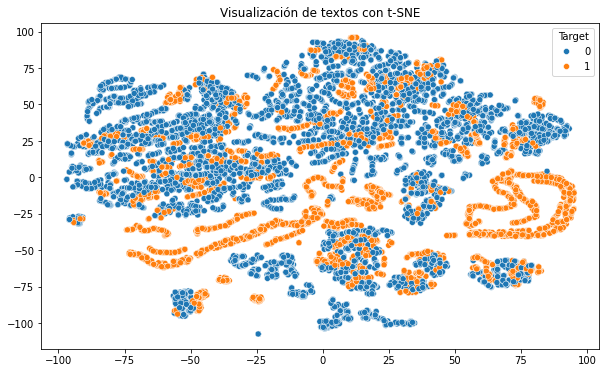

In [27]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns



tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_train_emb)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y_train, palette='tab10')
plt.title('Visualización de textos con t-SNE')
plt.show()

## PCA to Embeddings

In [51]:
from sklearn.decomposition import PCA
import numpy as np
# Definir PCA, por ejemplo para retener 95% de varianza
pca = PCA(n_components=0.95, random_state=42)

X_train_pca = pca.fit_transform(X)
# X_val_pca = pca.transform(X_val_emb)
X_test_pca = pca.transform(X_test_emb)


In [38]:
print("Dimensiones originales:", X_train_emb.shape, X_val_emb.shape, X_test_emb.shape)
print("Dimensiones reducidas:", X_train_pca.shape, X_val_pca.shape, X_test_pca.shape)

Dimensiones originales: (13635, 2048) (3273, 2048) (2227, 2048)
Dimensiones reducidas: (13635, 17) (3273, 17) (2227, 17)


In [52]:
X_train_pca.shape, X_test_pca.shape

((16908, 607), (2227, 607))

In [19]:
pickle.dump([X_train_pca, X_val_pca, X_test_pca], open('../data/dataset_pca_train_val_test.pk', 'wb'))

## XGBoost regularizacion, predefined split, pca auc_roc 0.56

In [53]:

n_neg = np.sum(y_train == 0)
n_pos = np.sum(y_train == 1)
spw = n_neg / n_pos

xgb_gpu = XGBClassifier(
    objective='binary:logistic',
    tree_method='hist',
    device='cuda:1',
    eval_metric='aucpr',
    min_child_weight=3,
    max_depth=6,
    reg_lambda=0,
    gamma=7,
    learning_rate=0.3,
    scale_pos_weight=spw,
    random_state=42,
    n_jobs=1
)

xgb_param_grid = {
    'n_estimators': [50, 100],
    'reg_alpha':  [0.1, 1.0, 10.0],
    'subsample': [0.7, 1.0],
}

grid_search = GridSearchCV(
        estimator=xgb_gpu,
        param_grid=xgb_param_grid,
        cv=ps,
        n_jobs=1,
        verbose=2,
        scoring='roc_auc')

grid_search.fit(X_train_pca, y)

Fitting 1 folds for each of 12 candidates, totalling 12 fits
[CV] END ......n_estimators=50, reg_alpha=0.1, subsample=0.7; total time=   1.6s
[CV] END ......n_estimators=50, reg_alpha=0.1, subsample=1.0; total time=   1.5s
[CV] END ......n_estimators=50, reg_alpha=1.0, subsample=0.7; total time=   1.5s
[CV] END ......n_estimators=50, reg_alpha=1.0, subsample=1.0; total time=   1.5s
[CV] END .....n_estimators=50, reg_alpha=10.0, subsample=0.7; total time=   1.5s
[CV] END .....n_estimators=50, reg_alpha=10.0, subsample=1.0; total time=   1.5s
[CV] END .....n_estimators=100, reg_alpha=0.1, subsample=0.7; total time=   1.6s
[CV] END .....n_estimators=100, reg_alpha=0.1, subsample=1.0; total time=   1.6s
[CV] END .....n_estimators=100, reg_alpha=1.0, subsample=0.7; total time=   1.7s
[CV] END .....n_estimators=100, reg_alpha=1.0, subsample=1.0; total time=   1.6s
[CV] END ....n_estimators=100, reg_alpha=10.0, subsample=0.7; total time=   1.6s
[CV] END ....n_estimators=100, reg_alpha=10.0, s

,estimator,"XGBClassifier...ree=None, ...)"
,param_grid,"{'n_estimators': [50, 100], 'reg_alpha': [0.1, 1.0, ...], 'subsample': [0.7, 1.0]}"
,scoring,'roc_auc'
,n_jobs,1
,refit,True
,cv,"PredefinedSpl...ape=(16908,)))"
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'binary:logistic'


In [54]:
# mejor hiperparametro y modelo para XGBoost

best_model_xb_pca = grid_search.best_estimator_
best_param3_xb_pca = grid_search.best_params_
best_param3_xb_pca

{'n_estimators': 50, 'reg_alpha': 0.1, 'subsample': 1.0}

In [55]:
y_pred_pca = best_model_xb_pca.predict(X_test_pca)
xgb_report_pca = classification_report(y_test, y_pred_pca)
print(xgb_report_pca)

              precision    recall  f1-score   support

           0       0.82      0.88      0.85      1824
           1       0.20      0.13      0.16       403

    accuracy                           0.75      2227
   macro avg       0.51      0.51      0.51      2227
weighted avg       0.71      0.75      0.73      2227



In [56]:
y_proba = best_model_xb_pca.predict_proba(X_test_pca)[:,1]
auc = roc_auc_score(y_test, y_proba)
print("AUC-ROC:", auc)

AUC-ROC: 0.5579929585129075


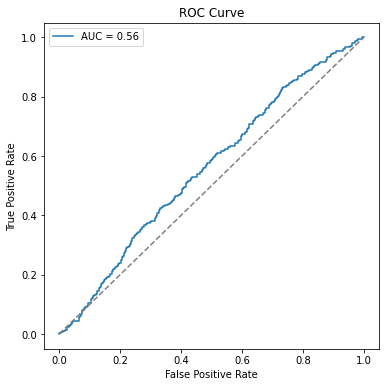

In [42]:
# Obtener puntos FPR (False Positive Rate), TPR (True Positive Rate)
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0,1], [0,1], linestyle='--', color='gray')  # línea aleatoria
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

## Logistic Regression 

In [48]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score


In [38]:
params = {"C": [0.01, 0.1],
          "penalty": ["l1", "l2"],
         }

log_reg_grid = GridSearchCV(LogisticRegression(solver='liblinear'),
                            params,
                            cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                            scoring= "roc_auc",
                            n_jobs= -1,
                            verbose = 2                         
                           )
log_reg_grid.fit(X_train_emb, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


,estimator,LogisticRegre...r='liblinear')
,param_grid,"{'C': [0.01, 0.1], 'penalty': ['l1', 'l2']}"
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,penalty,'l2'


In [39]:
best_model = log_reg_grid.best_estimator_
y_pred = best_model.predict(X_val_emb)
lg_report = classification_report(y_val, y_pred)
print(lg_report)


              precision    recall  f1-score   support

           0       0.73      0.62      0.67      2552
           1       0.12      0.18      0.14       721

    accuracy                           0.52      3273
   macro avg       0.42      0.40      0.41      3273
weighted avg       0.59      0.52      0.55      3273

